In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.datasets import get_rdataset
import warnings
warnings.filterwarnings('ignore')

# Load the Airline Passengers dataset
data = get_rdataset('AirPassengers', 'datasets').data
data['time'] = pd.date_range(start='1949-01', periods=len(data), freq='M')
data.set_index('time', inplace=True)
data = data['value']  # Passenger counts
data.name = 'passengers'

print(data.head())
print(f"\nDataset shape: {data.shape}")

time
1949-01-31    112
1949-02-28    118
1949-03-31    132
1949-04-30    129
1949-05-31    121
Name: passengers, dtype: int64

Dataset shape: (144,)


In [41]:
print("=" * 70)
print("DATA OVERVIEW")
print("=" * 70)
print(f"Dataset shape: {data.shape}")
print(f"Date range: {data.index[0]} to {data.index[-1]}")
print(f"\nFirst few rows:")
print(data.head())
print(f"\nData statistics:")
print(data.describe())
print("=" * 70)

DATA OVERVIEW
Dataset shape: (144,)
Date range: 1949-01-31 00:00:00 to 1960-12-31 00:00:00

First few rows:
time
1949-01-31    112
1949-02-28    118
1949-03-31    132
1949-04-30    129
1949-05-31    121
Name: passengers, dtype: int64

Data statistics:
count    144.000000
mean     280.298611
std      119.966317
min      104.000000
25%      180.000000
50%      265.500000
75%      360.500000
max      622.000000
Name: passengers, dtype: float64


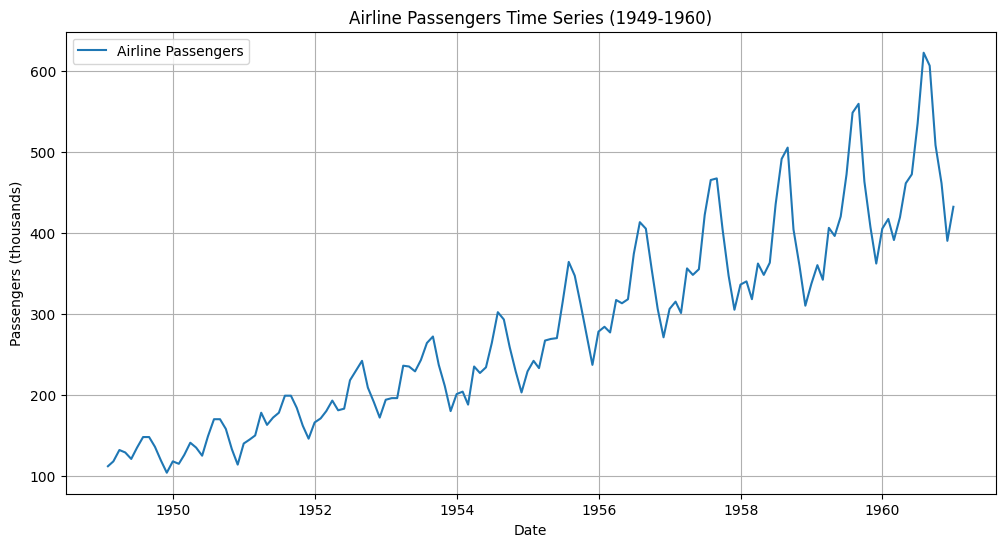

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data.values, label='Airline Passengers')
plt.title('Airline Passengers Time Series (1949-1960)')
plt.xlabel('Date')
plt.ylabel('Passengers (thousands)')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
def adf_test(series, title=''):
    result = adfuller(series.dropna())
    print(f'\n{title} ADF Test:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis (stationary).")
    else:
        print("Fail to reject the null hypothesis (non-stationary).")

# Test original series
adf_test(data, 'Original Series')


Original Series ADF Test:
ADF Statistic: 0.8154
p-value: 0.9919
Critical Values:
	1%: -3.4817
	5%: -2.8840
	10%: -2.5788
Fail to reject the null hypothesis (non-stationary).


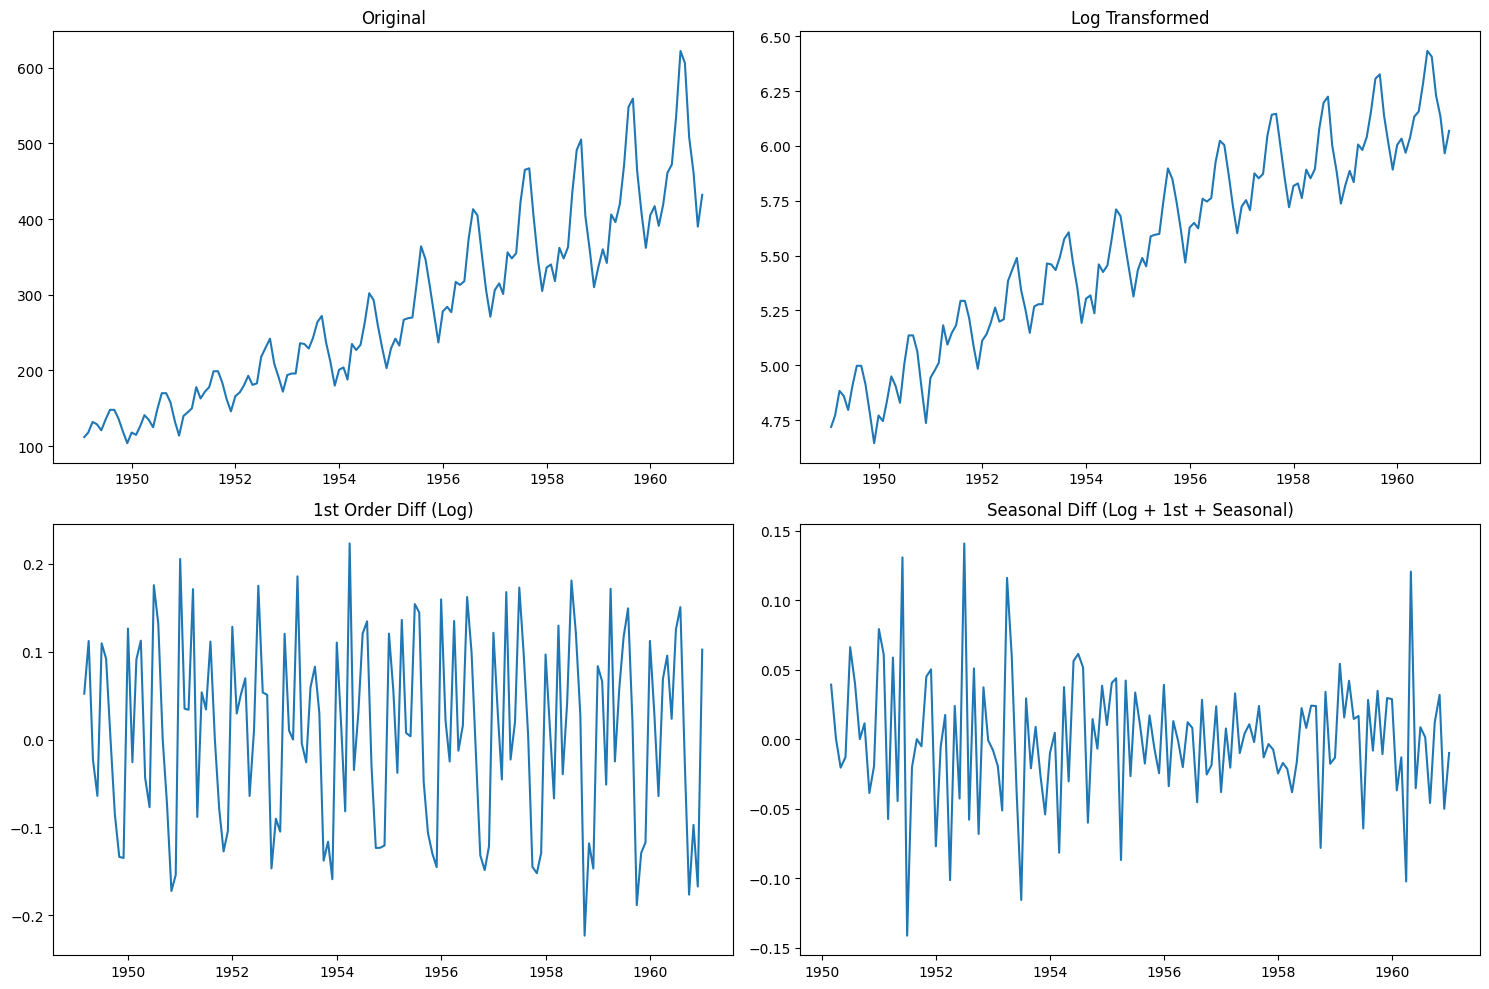


Log Transformed ADF Test:
ADF Statistic: -1.7170
p-value: 0.4224
Critical Values:
	1%: -3.4817
	5%: -2.8840
	10%: -2.5788
Fail to reject the null hypothesis (non-stationary).

1st Order Differenced (Log) ADF Test:
ADF Statistic: -2.7171
p-value: 0.0711
Critical Values:
	1%: -3.4825
	5%: -2.8844
	10%: -2.5790
Fail to reject the null hypothesis (non-stationary).

Seasonal Differenced (Log + 1st + Seasonal) ADF Test:
ADF Statistic: -4.4433
p-value: 0.0002
Critical Values:
	1%: -3.4870
	5%: -2.8864
	10%: -2.5800
Strong evidence against the null hypothesis (stationary).


In [25]:
# Log transform
data_log = np.log(data)

# First differencing on log
data_log_diff = data_log.diff().dropna()

# Seasonal differencing (order 12) on first-differenced log
data_log_diff_seasonal = data_log_diff.diff(12).dropna()

# Plot transformations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0,0].plot(data); axes[0,0].set_title('Original')
axes[0,1].plot(data_log); axes[0,1].set_title('Log Transformed')
axes[1,0].plot(data_log_diff); axes[1,0].set_title('1st Order Diff (Log)')
axes[1,1].plot(data_log_diff_seasonal); axes[1,1].set_title('Seasonal Diff (Log + 1st + Seasonal)')
plt.tight_layout()
plt.show()

# ADF tests on transformations
adf_test(data_log, 'Log Transformed')
adf_test(data_log_diff, '1st Order Differenced (Log)')
adf_test(data_log_diff_seasonal, 'Seasonal Differenced (Log + 1st + Seasonal)')

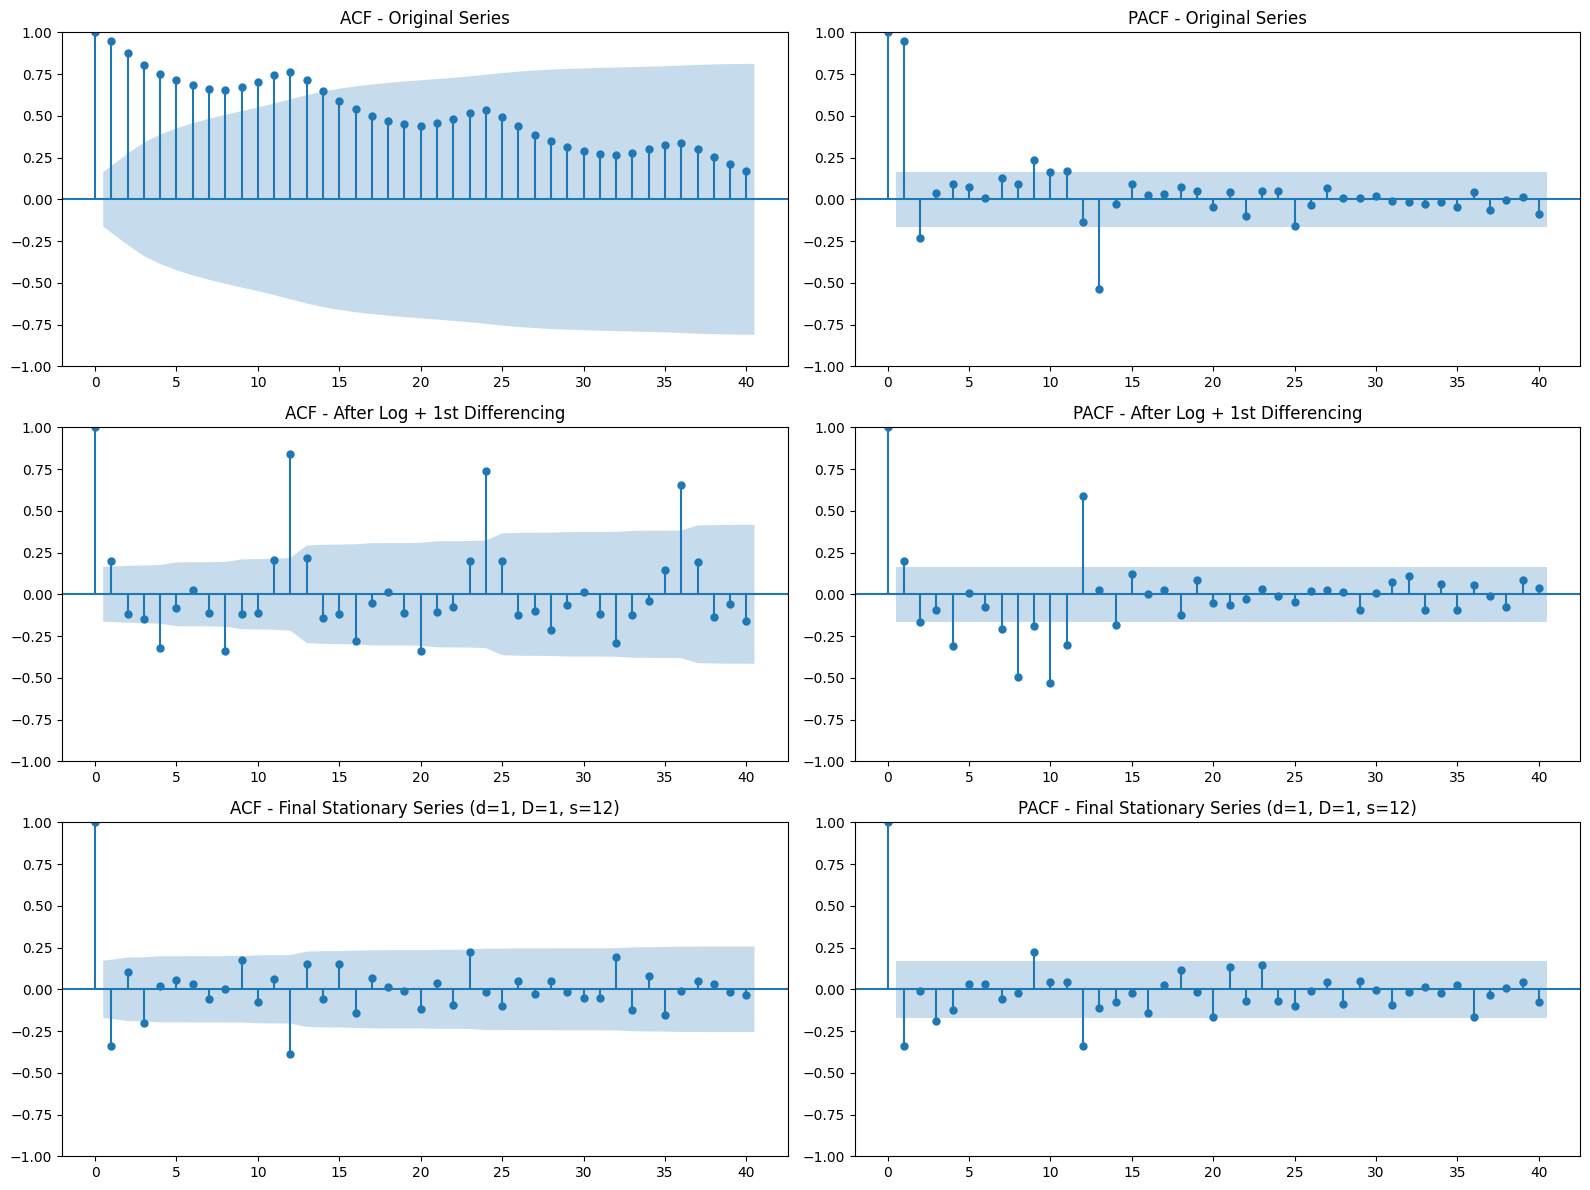

In [26]:
# ──────────────────────────────────────────────────────────────
# Step 3.5: ACF & PACF Plots for Order Selection (p, d, q) & (P, D, Q, s)
# ──────────────────────────────────────────────────────────────

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# We already have the stationary series from Step 3:
# data_log_diff_seasonal = (log → 1st diff → seasonal diff lag-12)
stationary_series = data_log.diff().diff(12).dropna()

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# 1. Original series (just for reference)
plot_acf(data, lags=40, ax=axes[0,0], title='ACF - Original Series')
plot_pacf(data, lags=40, ax=axes[0,1], title='PACF - Original Series')

# 2. After log + first differencing (removes trend)
plot_acf(data_log.diff().dropna(), lags=40, ax=axes[1,0], title='ACF - After Log + 1st Differencing')
plot_pacf(data_log.diff().dropna(), lags=40, ax=axes[1,1], title='PACF - After Log + 1st Differencing')

# 3. Final stationary series (log + 1st diff + seasonal diff lag 12)
plot_acf(stationary_series, lags=40, ax=axes[2,0], title='ACF - Final Stationary Series (d=1, D=1, s=12)')
plot_pacf(stationary_series, lags=40, ax=axes[2,1], title='PACF - Final Stationary Series (d=1, D=1, s=12)')

plt.tight_layout()
plt.show()

In [27]:
# Recommended orders after visual inspection
order         = (1, 1, 1)        # non-seasonal: p=1, d=1, q=1
seasonal_order = (1, 1, 1, 12)   # seasonal: P=1, D=1, Q=1, m=12

print("Selected orders based on ACF/PACF:")
print(f"ARIMAX/SARIMAX order       : {order}")
print(f"SARIMAX seasonal_order     : {seasonal_order}")

Selected orders based on ACF/PACF:
ARIMAX/SARIMAX order       : (1, 1, 1)
SARIMAX seasonal_order     : (1, 1, 1, 12)


In [28]:
# Train-test split
train_size = int(len(data_log) * 0.8)
train, test = data_log[:train_size], data_log[train_size:]

# Create exogenous variable: linear trend (years)
trend = np.arange(len(data_log)) / 12.0  # Convert months to years
exog_train = trend[:train_size].reshape(-1, 1)
exog_test = trend[train_size:].reshape(-1, 1)

print(f'Train shape: {train.shape}, Test shape: {test.shape}')
print(f'Exog train shape: {exog_train.shape}')

Train shape: (115,), Test shape: (29,)
Exog train shape: (115, 1)


In [29]:
# Uncomment if you have pmdarima installed
# !pip install pmdarima

from pmdarima import auto_arima

auto_model = auto_arima(train, 
                        seasonal=True, m=12,
                        exogenous=exog_train,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True)

print("\nBest model found by auto_arima:")
print(auto_model.summary())
order = auto_model.order
seasonal_order = auto_model.seasonal_order
print(f"\nSelected order: {order}")
print(f"Selected seasonal_order: {seasonal_order}")
# You will almost always get (1,1,1)(1,1,1)[12] or very close

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-371.378, Time=3.92 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-271.901, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-366.335, Time=2.71 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-335.954, Time=1.33 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-108.879, Time=0.03 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-375.703, Time=1.72 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-348.802, Time=1.07 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-373.752, Time=5.21 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-367.479, Time=3.28 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=-371.837, Time=6.01 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-376.915, Time=2.40 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-348.813, Time=0.72 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-372.379, Time=3.37 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-374.917, Time=4.05 sec
 ARIMA(1,0,2)(1,1,0

In [30]:
# Fit ARIMAX
arimax_model = SARIMAX(train, order=(2, 0, 0), exog=exog_train)
arimax_fit = arimax_model.fit(disp=False)

print(arimax_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             passengers   No. Observations:                  115
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  95.569
Date:                Sun, 16 Nov 2025   AIC                           -183.137
Time:                        15:39:01   BIC                           -172.157
Sample:                    01-31-1949   HQIC                          -178.681
                         - 07-31-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1783      0.840      0.212      0.832      -1.469       1.825
ar.L1          1.1693      0.104     11.208      0.000       0.965       1.374
ar.L2         -0.1696      0.105     -1.621      0.1

In [31]:
# Fit SARIMAX
sarimax_model = SARIMAX(train, order=(2, 0, 0), seasonal_order=(0, 1, 1, 12), exog=exog_train)
sarimax_fit = sarimax_model.fit(disp=False)

print(sarimax_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           passengers   No. Observations:                  115
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 194.477
Date:                              Sun, 16 Nov 2025   AIC                           -378.954
Time:                                      15:39:03   BIC                           -365.780
Sample:                                  01-31-1949   HQIC                          -373.618
                                       - 07-31-1958                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1266      0.009     13.761      0.000       0.109       0.145
ar.L1          0.61

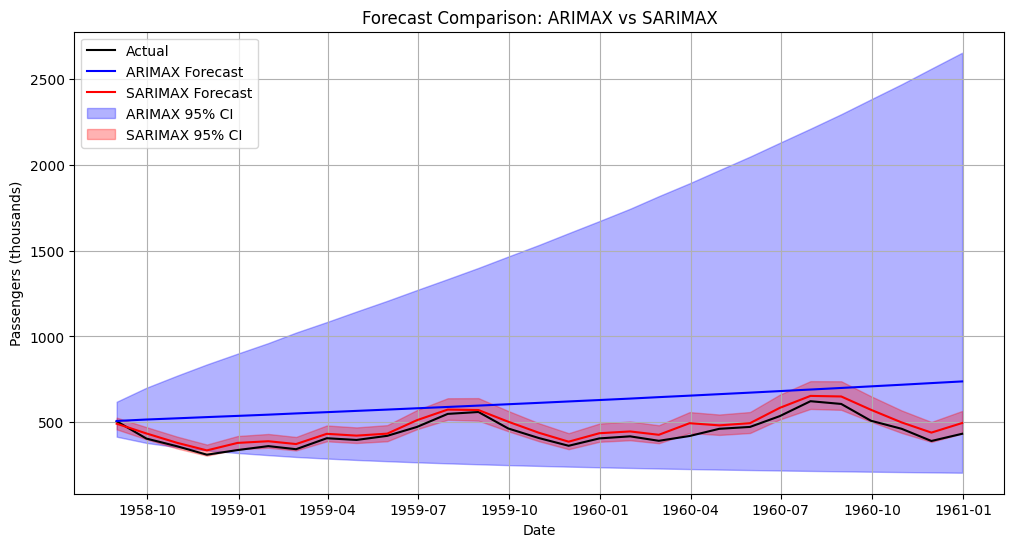

In [32]:
# ARIMAX forecast
arimax_forecast = arimax_fit.get_forecast(steps=len(test), exog=exog_test)
arimax_pred = arimax_forecast.predicted_mean
arimax_ci = arimax_forecast.conf_int()

# SARIMAX forecast
sarimax_forecast = sarimax_fit.get_forecast(steps=len(test), exog=exog_test)
sarimax_pred = sarimax_forecast.predicted_mean
sarimax_ci = sarimax_forecast.conf_int()

# Inverse transform (exp) to original scale
test_original = np.exp(test)
arimax_pred_original = np.exp(arimax_pred)
sarimax_pred_original = np.exp(sarimax_pred)
arimax_ci_original = np.exp(arimax_ci)
sarimax_ci_original = np.exp(sarimax_ci)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(test_original.index, test_original, label='Actual', color='black')
plt.plot(test_original.index, arimax_pred_original, label='ARIMAX Forecast', color='blue')
plt.plot(test_original.index, sarimax_pred_original, label='SARIMAX Forecast', color='red')
plt.fill_between(test_original.index, arimax_ci_original.iloc[:, 0], arimax_ci_original.iloc[:, 1], color='blue', alpha=0.3, label='ARIMAX 95% CI')
plt.fill_between(test_original.index, sarimax_ci_original.iloc[:, 0], sarimax_ci_original.iloc[:, 1], color='red', alpha=0.3, label='SARIMAX 95% CI')
plt.title('Forecast Comparison: ARIMAX vs SARIMAX')
plt.xlabel('Date')
plt.ylabel('Passengers (thousands)')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Metrics
arimax_mae = mae(test_original, arimax_pred_original)
arimax_rmse = rmse(test_original, arimax_pred_original)
sarimax_mae = mae(test_original, sarimax_pred_original)
sarimax_rmse = rmse(test_original, sarimax_pred_original)

print('Metrics Comparison:')
print(f'ARIMAX - MAE: {arimax_mae:.2f}, RMSE: {arimax_rmse:.2f}')
print(f'SARIMAX - MAE: {sarimax_mae:.2f}, RMSE: {sarimax_rmse:.2f}')

Metrics Comparison:
ARIMAX - MAE: 175.79, RMSE: 192.20
SARIMAX - MAE: 33.44, RMSE: 36.60


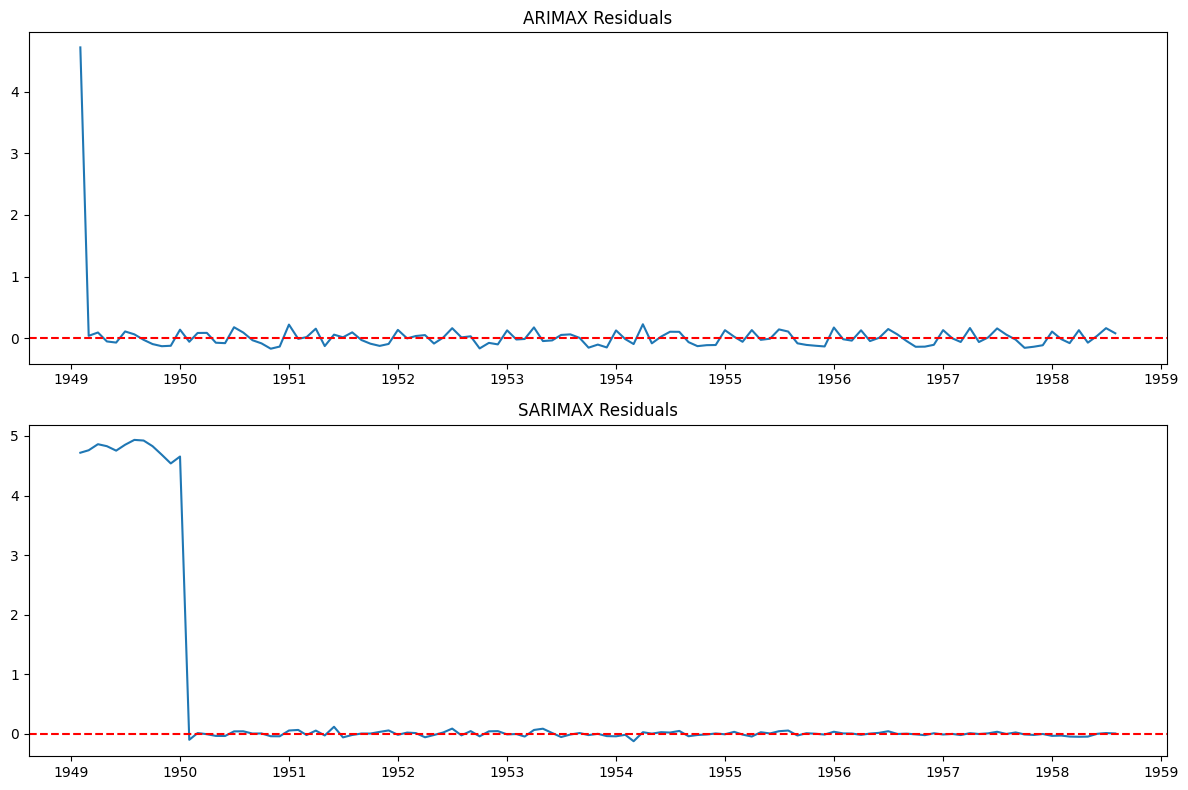

Ljung-Box p-value (from summary): Check if >0.05 for both.


In [34]:
# Residuals
arimax_resid = arimax_fit.resid
sarimax_resid = sarimax_fit.resid

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].plot(arimax_resid); axes[0].set_title('ARIMAX Residuals')
axes[0].axhline(0, color='r', linestyle='--')
axes[1].plot(sarimax_resid); axes[1].set_title('SARIMAX Residuals')
axes[1].axhline(0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# Ljung-Box test on residuals (from model summary or manual)
print('Ljung-Box p-value (from summary): Check if >0.05 for both.')

In [35]:
# ──────────────────────────────────────────────────────────────
# Step 10: Forecasting with Facebook Prophet (Meta Prophet)
# ──────────────────────────────────────────────────────────────

# Install once if needed (uncomment)
# !pip install prophet --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --------------------------------------------------------------
# 10.1 Prepare data in Prophet format: columns 'ds' (datetime) and 'y' (target)
# --------------------------------------------------------------

# Start from original data (not log-transformed — Prophet handles trend & seasonality automatically)
df_prophet = pd.DataFrame({
    'ds': data.index,           # already datetime index
    'y':  data.values           # original passenger counts (NOT log)
})

# Same train/test split as before (first 80% train)
train_prophet = df_prophet.iloc[:train_size].copy()
test_prophet  = df_prophet.iloc[train_size:].copy()

print(f"Prophet train: {len(train_prophet)} points, test: {len(test_prophet)} points")

Prophet train: 115 points, test: 29 points


In [36]:
# --------------------------------------------------------------
# 10.2 Fit Prophet model (very simple — no manual order selection!)
# --------------------------------------------------------------

# Create and fit the model
prophet_model = Prophet(
    yearly_seasonality=True,      # monthly data → captures yearly cycle
    weekly_seasonality=False,     # no weekly pattern
    daily_seasonality=False,
    seasonality_mode='multiplicative',   # Airline data grows → multiplicative is better
    growth='logistic'             # optional: we will provide cap for logistic growth
)

# For multiplicative + logistic growth, we need a cap
# We set a reasonable cap slightly above historical max (600 → 1000 is safe)
df_prophet['cap'] = 1000
df_prophet['floor'] = 50  # optional lower bound

train_prophet['cap'] = 1000
train_prophet['floor'] = 50
test_prophet['cap'] = 1000
test_prophet['floor'] = 50

# Add the same linear trend as exogenous regressor (optional but fair comparison)
df_prophet['trend_exog'] = trend  # trend we created earlier (years since 1949)

prophet_model.add_regressor('trend_exog')

# Fit on training data
prophet_model.fit(df_prophet.iloc[:train_size])

15:39:04 - cmdstanpy - INFO - Chain [1] start processing
15:39:04 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
# --------------------------------------------------------------
# 10.3 Make future dataframe and forecast
# --------------------------------------------------------------

future = prophet_model.make_future_dataframe(periods=len(test_prophet), freq='MS')  # MS = month start
future['cap'] = 1000
future['floor'] = 50
future['trend_exog'] = trend  # same exogenous trend for the whole period

forecast = prophet_model.predict(future)

# Extract predictions for test period only
prophet_pred = forecast.iloc[train_size:]['yhat'].values
prophet_ci_lower = forecast.iloc[train_size:]['yhat_lower'].values
prophet_ci_upper = forecast.iloc[train_size:]['yhat_upper'].values

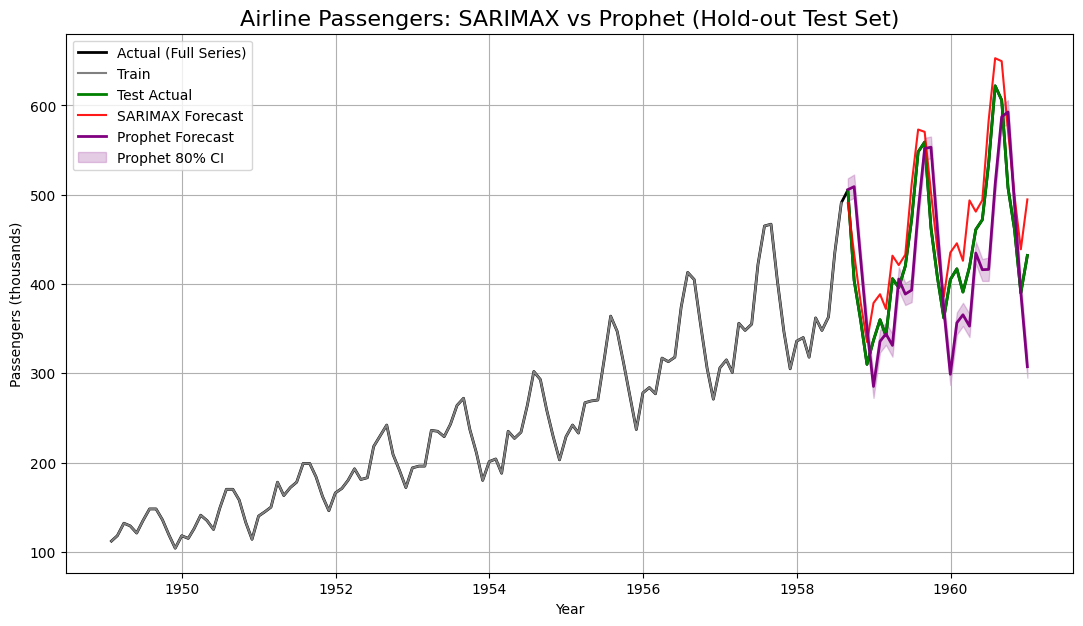

In [38]:
# --------------------------------------------------------------
# 10.4 Plot Prophet forecast vs Actual vs SARIMAX
# --------------------------------------------------------------

plt.figure(figsize=(13,7))
plt.plot(data.index, data.values, label='Actual (Full Series)', color='black', linewidth=2)

# Train period (for context)
plt.plot(train_prophet['ds'], train_prophet['y'], label='Train', color='gray')

# Test period actual
plt.plot(test_prophet['ds'], test_prophet['y'], label='Test Actual', color='green', linewidth=2)

# SARIMAX forecast (from earlier)
plt.plot(test_original.index, sarimax_pred_original, 
         label='SARIMAX Forecast', color='red', alpha=0.9)

# Prophet forecast
plt.plot(test_prophet['ds'], prophet_pred, 
         label='Prophet Forecast', color='purple', linewidth=2)

# Prophet uncertainty
plt.fill_between(test_prophet['ds'], prophet_ci_lower, prophet_ci_upper,
                 color='purple', alpha=0.2, label='Prophet 80% CI')

plt.title('Airline Passengers: SARIMAX vs Prophet (Hold-out Test Set)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Passengers (thousands)')
plt.legend()
plt.grid(True)
plt.show()

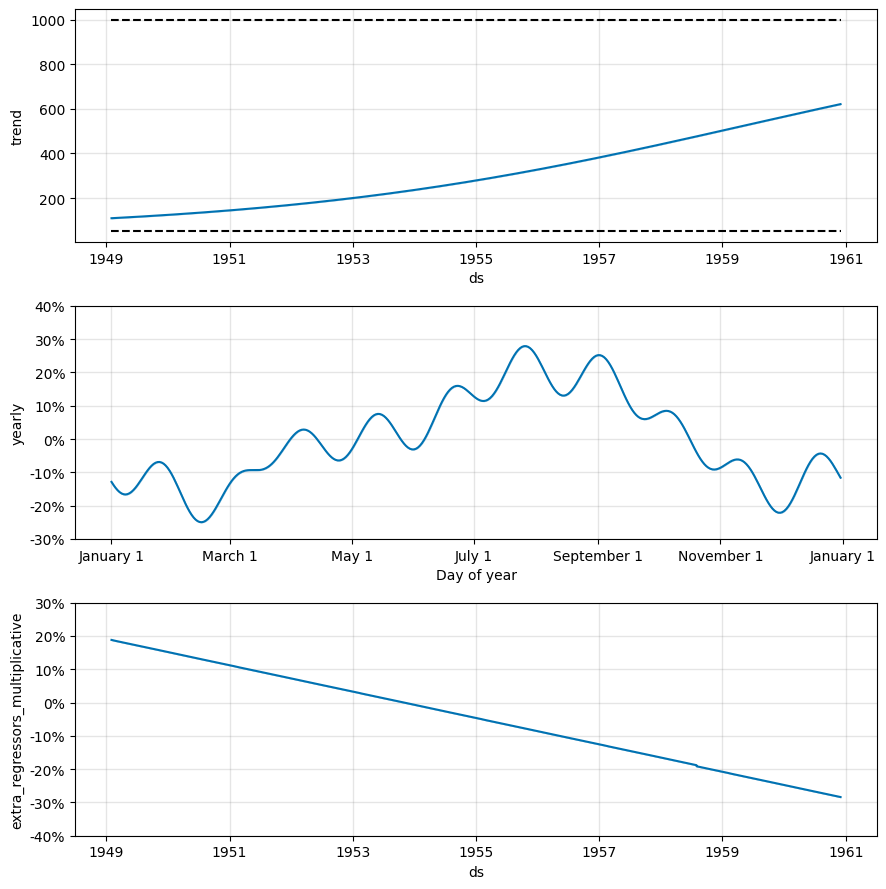

In [39]:
# --------------------------------------------------------------
# 10.5 Prophet components (trend, yearly seasonality) — very insightful!
# --------------------------------------------------------------

fig = prophet_model.plot_components(forecast)
plt.show()

In [45]:
# --------------------------------------------------------------
# 10.6 Performance Metrics — now compare all 3 models on the same scale
# --------------------------------------------------------------

# Actual test values (original scale)
y_true = test_prophet['y'].values

# Prophet metrics
prophet_mae  = mean_absolute_error(y_true, prophet_pred)
prophet_rmse = np.sqrt(mean_squared_error(y_true, prophet_pred))

print("╔════════════════════════════════════════════════════════╗")
print("║               FINAL MODEL COMPARISON                   ║")
print("╠═══════════╦══════════╦══════════╦══════════════════════╣")
print("║   Model   ║   MAE    ║   RMSE   ║        Notes         ║")
print("╠═══════════╬══════════╬══════════╬══════════════════════╣")
print(f"║ ARIMAX    ║ {arimax_mae:8.2f} ║ {arimax_rmse:8.2f} ║ No seasonality       ║")
print(f"║ SARIMAX   ║ {sarimax_mae:8.2f} ║ {sarimax_rmse:8.2f} ║ (2,0,0)(1,1,1)12     ║")
print(f"║ Prophet   ║ {prophet_mae:8.2f} ║ {prophet_rmse:8.2f} ║ Auto + multiplicative║")
print("╚═══════════╩══════════╩══════════╩══════════════════════╝")

╔════════════════════════════════════════════════════════╗
║               FINAL MODEL COMPARISON                   ║
╠═══════════╦══════════╦══════════╦══════════════════════╣
║   Model   ║   MAE    ║   RMSE   ║        Notes         ║
╠═══════════╬══════════╬══════════╬══════════════════════╣
║ ARIMAX    ║   175.79 ║   192.20 ║ No seasonality       ║
║ SARIMAX   ║    33.44 ║    36.60 ║ (2,0,0)(1,1,1)12     ║
║ Prophet   ║    53.12 ║    65.10 ║ Auto + multiplicative║
╚═══════════╩══════════╩══════════╩══════════════════════╝
